In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

# КЛАСТЕРИЗАЦІЯ DBSCAN
print("\n" + "="*80)
print("КЛАСТЕРИЗАЦІЯ DBSCAN")
print("="*80)

# 1.1 Завантаження та попередня обробка даних
print("\nЗавантаження та попередня обробка даних...")

# Завантаження датасету
df = pd.read_csv('../DATASETS/L8/cybersecurity_attacks.csv')
print(f"Датасет завантажено: {df.shape[0]} рядків, {df.shape[1]} стовпців")




КЛАСТЕРИЗАЦІЯ DBSCAN

Завантаження та попередня обробка даних...
Датасет завантажено: 40000 рядків, 25 стовпців


In [39]:
# Аналіз цільової змінної
print("\nАналіз розподілу Attack Type...")
attack_counts = df['Attack Type'].value_counts()
print(attack_counts)
print(f"\nКількість унікальних типів атак: {len(attack_counts)}")




Аналіз розподілу Attack Type...
Attack Type
DDoS         13428
Malware      13307
Intrusion    13265
Name: count, dtype: int64

Кількість унікальних типів атак: 3


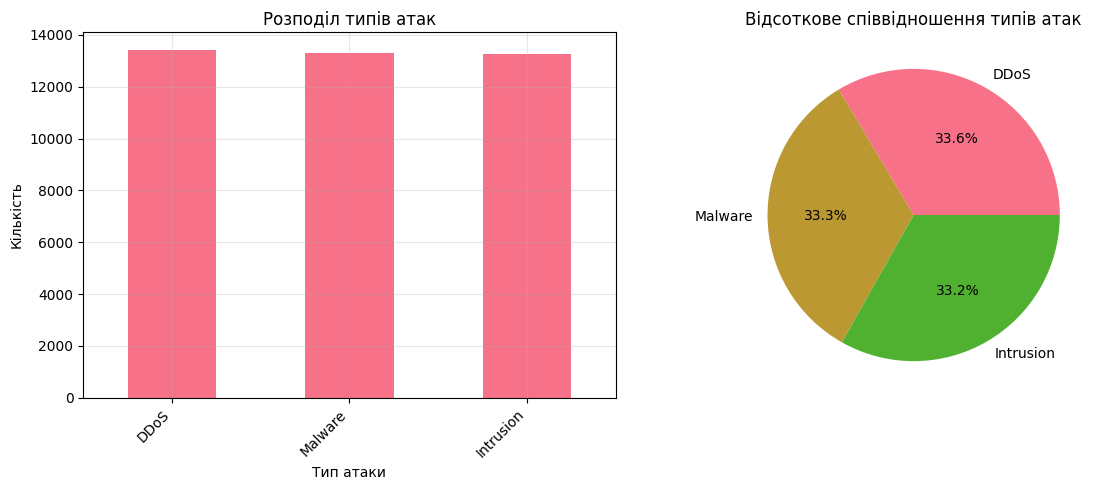

In [40]:
# Візуалізація розподілу класів
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
attack_counts.plot(kind='bar')
plt.xlabel('Тип атаки')
plt.ylabel('Кількість')
plt.title('Розподіл типів атак')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
attack_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Відсоткове співвідношення типів атак')
plt.ylabel('')
plt.tight_layout()
plt.show()



In [41]:
# Вибір ознак для кластеризації
feature_cols = ['Source Port', 'Destination Port', 'Packet Length', 
                'Anomaly Scores', 'Severity Level', 'Protocol', 'Traffic Type']

# Перевірка наявності всіх необхідних колонок
missing_cols = [col for col in feature_cols if col not in df.columns]
if missing_cols:
    print(f"WARNING: Відсутні колонки: {missing_cols}")
    feature_cols = [col for col in feature_cols if col in df.columns]

df_clustering = df[feature_cols + ['Attack Type']].copy()

# Обробка пропущених значень
if df_clustering.isnull().any().any():
    print("Видалення рядків з пропущеними значеннями...")
    df_clustering = df_clustering.dropna()

print(f"Вибрано {len(feature_cols)} ознак для кластеризації")
print(f"Розмір датасету після очищення: {df_clustering.shape[0]} рядків")

# Збереження цільової змінної
attack_type_original = df_clustering['Attack Type'].copy()
df_features = df_clustering.drop('Attack Type', axis=1)

# Обробка категоріальних даних (One-Hot Encoding)
print("\nOne-Hot Encoding для категоріальних ознак...")
categorical_cols = df_features.select_dtypes(include=['object']).columns.tolist()

if categorical_cols:
    df_encoded = pd.get_dummies(df_features, columns=categorical_cols, drop_first=False)
    print(f"Застосовано One-Hot Encoding до: {categorical_cols}")
else:
    df_encoded = df_features.copy()
    print("Категоріальні ознаки відсутні")

print(f"Розмір після кодування: {df_encoded.shape[1]} ознак")



Вибрано 7 ознак для кластеризації
Розмір датасету після очищення: 40000 рядків

One-Hot Encoding для категоріальних ознак...
Застосовано One-Hot Encoding до: ['Severity Level', 'Protocol', 'Traffic Type']
Розмір після кодування: 13 ознак


In [42]:
# Масштабування даних
print("\nМасштабування даних за допомогою StandardScaler...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)
print(f"Дані відмасштабовано: μ={X_scaled.mean():.4f}, σ={X_scaled.std():.4f}")

# Зниження розмірності (PCA) - збільшуємо кількість компонентів
print("\nЗниження розмірності за допомогою PCA...")




Масштабування даних за допомогою StandardScaler...
Дані відмасштабовано: μ=0.0000, σ=1.0000

Зниження розмірності за допомогою PCA...


In [43]:
# Спочатку визначаємо оптимальну кількість компонентів
pca_temp = PCA()
pca_temp.fit(X_scaled)
cumulative_variance = np.cumsum(pca_temp.explained_variance_ratio_)

# Знаходимо кількість компонентів для 95% дисперсії
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Для 95% дисперсії потрібно {n_components_95} компонентів")

# Використовуємо більше компонентів для кращої якості
n_components = min(20, X_scaled.shape[1], n_components_95 + 5)
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"PCA застосовано: {n_components} компонентів")
print(f"Кумулятивна дисперсія: {cumulative_variance[-1]*100:.2f}%")



Для 95% дисперсії потрібно 10 компонентів
PCA застосовано: 13 компонентів
Кумулятивна дисперсія: 100.00%


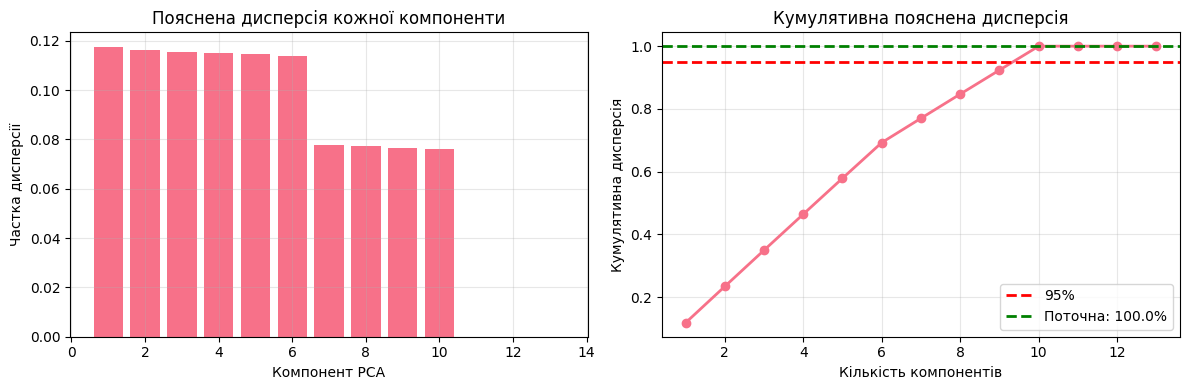

In [44]:
# Візуалізація дисперсії
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, n_components+1), pca.explained_variance_ratio_)
plt.xlabel('Компонент PCA')
plt.ylabel('Частка дисперсії')
plt.title('Пояснена дисперсія кожної компоненти')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, n_components+1), cumulative_variance, marker='o', linewidth=2, markersize=6)
plt.xlabel('Кількість компонентів')
plt.ylabel('Кумулятивна дисперсія')
plt.title('Кумулятивна пояснена дисперсія')
plt.axhline(y=0.95, color='r', linestyle='--', label='95%', linewidth=2)
plt.axhline(y=cumulative_variance[-1], color='g', linestyle='--', 
            label=f'Поточна: {cumulative_variance[-1]*100:.1f}%', linewidth=2)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




Побудова K-distance графіка для визначення epsilon...
MinPts встановлено: 26


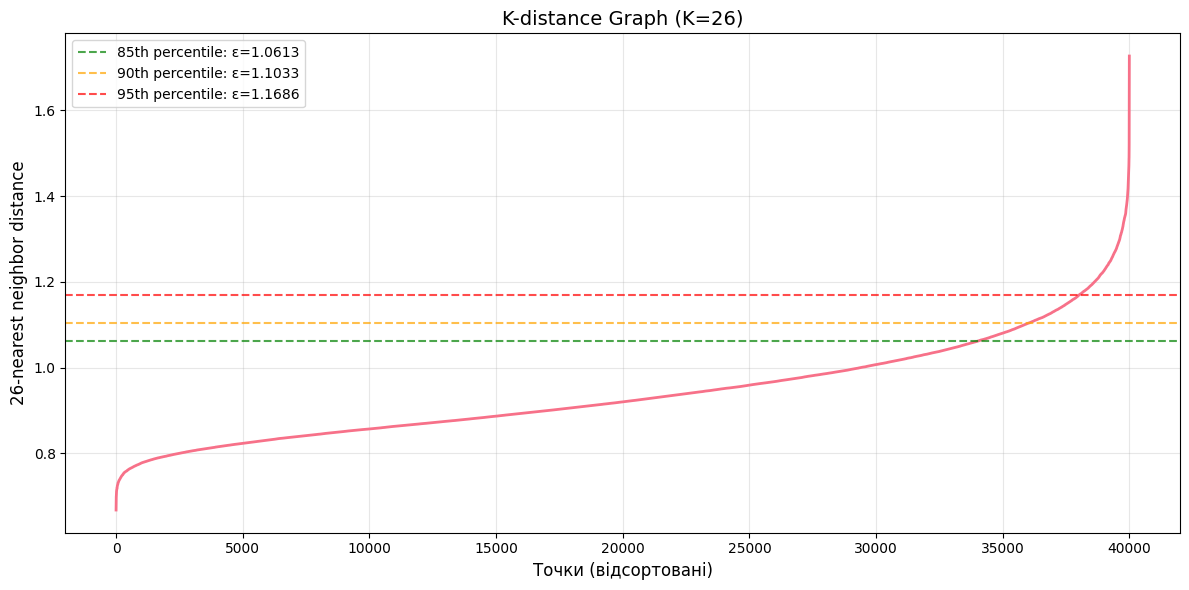

Рекомендоване значення epsilon: 1.1033
  (Експериментуйте зі значеннями від 1.0613 до 1.1686)


In [45]:
# Оптимізація параметрів DBSCAN
print("\nПобудова K-distance графіка для визначення epsilon...")

# Визначення MinPts
min_pts = 2 * n_components
print(f"MinPts встановлено: {min_pts}")

# Обчислення відстаней до k-го найближчого сусіда
neighbors = NearestNeighbors(n_neighbors=min_pts)
neighbors.fit(X_pca)
distances, indices = neighbors.kneighbors(X_pca)

# Сортування відстаней
distances = np.sort(distances[:, -1], axis=0)

# Візуалізація K-distance графіка з рекомендаціями
plt.figure(figsize=(12, 6))
plt.plot(distances, linewidth=2)
plt.xlabel('Точки (відсортовані)', fontsize=12)
plt.ylabel(f'{min_pts}-nearest neighbor distance', fontsize=12)
plt.title(f'K-distance Graph (K={min_pts})', fontsize=14)

# Позначаємо різні перцентилі для аналізу
percentiles = [85, 90, 95]
colors = ['green', 'orange', 'red']
for p, c in zip(percentiles, colors):
    value = np.percentile(distances, p)
    plt.axhline(y=value, color=c, linestyle='--', alpha=0.7, 
                label=f'{p}th percentile: ε={value:.4f}')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Автоматичне визначення epsilon (метод "коліна")
epsilon = np.percentile(distances, 90)
print(f"Рекомендоване значення epsilon: {epsilon:.4f}")
print(f"  (Експериментуйте зі значеннями від {np.percentile(distances, 85):.4f} до {np.percentile(distances, 95):.4f})")




Запуск алгоритму DBSCAN...

РЕЗУЛЬТАТИ КЛАСТЕРИЗАЦІЇ
Кількість знайдених кластерів: 27
Кількість шумових точок: 2 (0.01%)
Кількість точок у кластерах: 39998 (100.00%)

Розподіл точок по кластерах (топ-10 найбільших):
  Кластер 24: 1564 точок (3.9%)
  Кластер 3: 1543 точок (3.9%)
  Кластер 15: 1534 точок (3.8%)
  Кластер 6: 1520 точок (3.8%)
  Кластер 13: 1515 точок (3.8%)
  Кластер 19: 1510 точок (3.8%)
  Кластер 14: 1503 точок (3.8%)
  Кластер 0: 1500 точок (3.8%)
  Кластер 8: 1498 точок (3.7%)
  Кластер 23: 1485 точок (3.7%)

[1.8] Візуалізація результатів кластеризації...


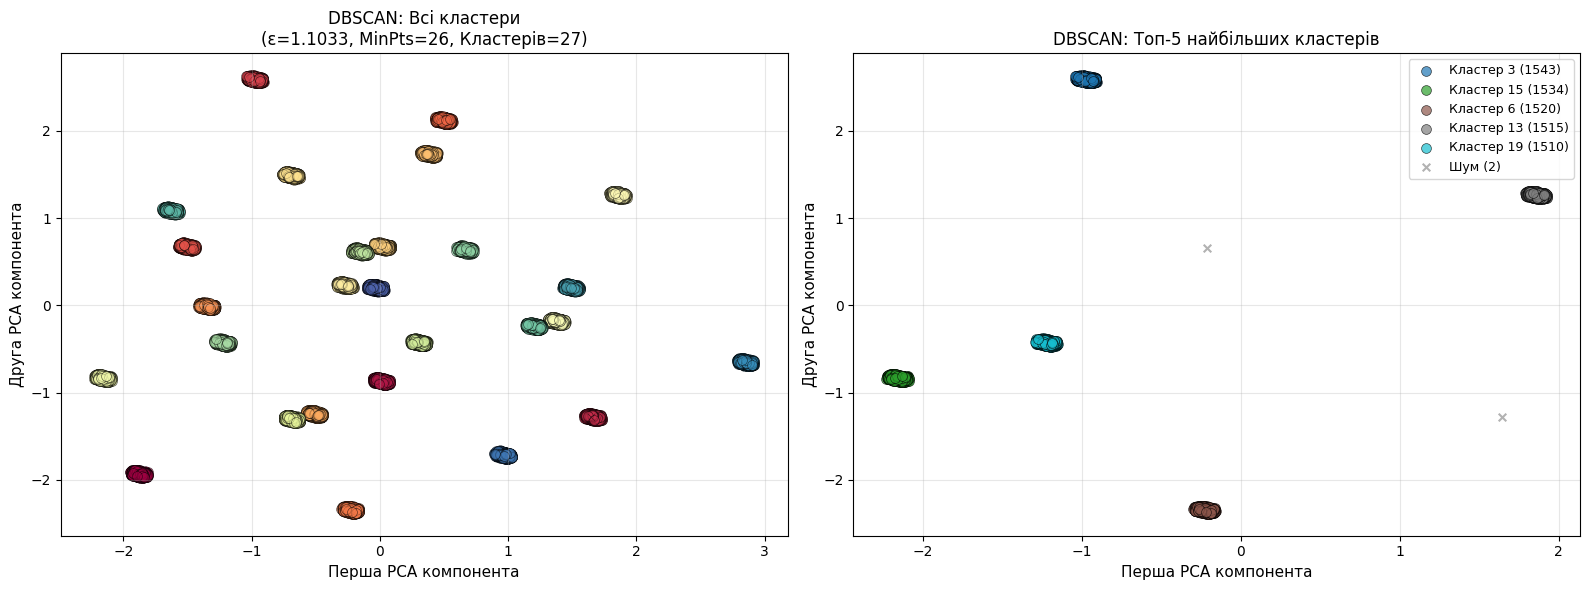

In [46]:
# Застосування DBSCAN
print("\nЗапуск алгоритму DBSCAN...")
dbscan = DBSCAN(eps=epsilon, min_samples=min_pts, n_jobs=-1)
clusters = dbscan.fit_predict(X_pca)

# Аналіз результатів кластеризації
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)
n_points = len(clusters)

print("\n" + "="*80)
print("РЕЗУЛЬТАТИ КЛАСТЕРИЗАЦІЇ")
print("="*80)
print(f"Кількість знайдених кластерів: {n_clusters}")
print(f"Кількість шумових точок: {n_noise} ({n_noise/n_points*100:.2f}%)")
print(f"Кількість точок у кластерах: {n_points - n_noise} ({(n_points-n_noise)/n_points*100:.2f}%)")

# Розподіл точок по кластерах
unique, counts = np.unique(clusters, return_counts=True)
print("\nРозподіл точок по кластерах (топ-10 найбільших):")
cluster_sizes = sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)
for i, (cluster_id, count) in enumerate(cluster_sizes[:10]):
    if cluster_id == -1:
        print(f"  Шум (мітка -1): {count} точок ({count/n_points*100:.1f}%)")
    else:
        print(f"  Кластер {cluster_id}: {count} точок ({count/n_points*100:.1f}%)")

# Візуалізація кластерів
print("\n[1.8] Візуалізація результатів кластеризації...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Графік 1: Всі кластери
unique_labels = set(clusters)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 0.5]
        marker = 'x'
        label = f'Шум ({list(clusters).count(-1)} точок)'
        size = 30
    else:
        marker = 'o'
        count = list(clusters).count(k)
        label = f'Кластер {k} ({count} точок)'
        size = 50
    
    class_member_mask = (clusters == k)
    xy = X_pca[class_member_mask]
    axes[0].scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, 
                   s=size, alpha=0.6, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('Перша PCA компонента', fontsize=11)
axes[0].set_ylabel('Друга PCA компонента', fontsize=11)
axes[0].set_title(f'DBSCAN: Всі кластери\n(ε={epsilon:.4f}, MinPts={min_pts}, Кластерів={n_clusters})', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Графік 2: Топ-5 найбільших кластерів
top_clusters = [c for c, _ in cluster_sizes[1:6] if c != -1]  # Пропускаємо шум
colors_top = plt.cm.tab10(np.linspace(0, 1, len(top_clusters)))

for k, col in zip(top_clusters, colors_top):
    class_member_mask = (clusters == k)
    xy = X_pca[class_member_mask]
    count = list(clusters).count(k)
    axes[1].scatter(xy[:, 0], xy[:, 1], c=[col], marker='o', 
                   s=50, alpha=0.7, label=f'Кластер {k} ({count})', 
                   edgecolors='black', linewidth=0.5)

# Додаємо шум
if n_noise > 0:
    noise_mask = (clusters == -1)
    xy_noise = X_pca[noise_mask]
    axes[1].scatter(xy_noise[:, 0], xy_noise[:, 1], c='black', marker='x', 
                   s=30, alpha=0.3, label=f'Шум ({n_noise})')

axes[1].set_xlabel('Перша PCA компонента', fontsize=11)
axes[1].set_ylabel('Друга PCA компонента', fontsize=11)
axes[1].set_title('DBSCAN: Топ-5 найбільших кластерів', fontsize=12)
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [47]:
# А/В-ТЕСТУВАННЯ МОДЕЛЕЙ МАШИННОГО НАВЧАННЯ

print("\n" + "="*80)
print("А/В-ТЕСТУВАННЯ МОДЕЛЕЙ")
print("="*80)

# Підготовка даних для класифікації
print("\nПідготовка даних для класифікації...")

# Кодування цільової змінної
le = LabelEncoder()
y = le.fit_transform(attack_type_original)
X = X_pca

print(f"Цільова змінна: Attack Type")
print(f"Класи ({len(le.classes_)}): {list(le.classes_)}")
print(f"Розмір датасету: X={X.shape}, y={y.shape}")

# Аналіз балансу класів
class_distribution = pd.Series(y).value_counts()
print(f"\nБаланс класів:")
for idx, count in class_distribution.items():
    print(f"  {le.classes_[idx]}: {count} ({count/len(y)*100:.1f}%)")

# Розбиття на навчальний та тестовий набори зі стратифікацією
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"\nНавчальний набір: {X_train.shape[0]} зразків ({X_train.shape[0]/len(y)*100:.1f}%)")
print(f"Тестовий набір: {X_test.shape[0]} зразків ({X_test.shape[0]/len(y)*100:.1f}%)")

#


А/В-ТЕСТУВАННЯ МОДЕЛЕЙ

Підготовка даних для класифікації...
Цільова змінна: Attack Type
Класи (3): ['DDoS', 'Intrusion', 'Malware']
Розмір датасету: X=(40000, 13), y=(40000,)

Баланс класів:
  DDoS: 13428 (33.6%)
  Malware: 13307 (33.3%)
  Intrusion: 13265 (33.2%)

Навчальний набір: 30000 зразків (75.0%)
Тестовий набір: 10000 зразків (25.0%)


In [48]:
# Тренування та оцінка моделей
print("\n Тренування моделей з оптимізацією гіперпараметрів...")

# Модель A (контрольна): Логістична регресія з підбором параметрів
print("\n--- Модель A: Логістична Регресія ---")
print("Підбір гіперпараметрів...")

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [1000]
}

model_a = GridSearchCV(
    LogisticRegression(random_state=42, multi_class='multinomial'),
    param_grid_lr,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=0
)
model_a.fit(X_train, y_train)

print(f"Найкращі параметри: {model_a.best_params_}")
y_pred_a = model_a.predict(X_test)

accuracy_a = accuracy_score(y_test, y_pred_a)
f1_a = f1_score(y_test, y_pred_a, average='weighted')

print(f"Точність (Accuracy): {accuracy_a:.4f}")
print(f"F1-міра (weighted): {f1_a:.4f}")

# Детальний звіт
print("\nДетальний звіт класифікації (Модель A):")
print(classification_report(y_test, y_pred_a, target_names=le.classes_, zero_division=0))




 Тренування моделей з оптимізацією гіперпараметрів...

--- Модель A: Логістична Регресія ---
Підбір гіперпараметрів...
Найкращі параметри: {'C': 10, 'max_iter': 1000, 'solver': 'lbfgs'}
Точність (Accuracy): 0.3283
F1-міра (weighted): 0.3186

Детальний звіт класифікації (Модель A):
              precision    recall  f1-score   support

        DDoS       0.33      0.49      0.40      3357
   Intrusion       0.32      0.21      0.25      3316
     Malware       0.33      0.28      0.30      3327

    accuracy                           0.33     10000
   macro avg       0.33      0.33      0.32     10000
weighted avg       0.33      0.33      0.32     10000



In [49]:
# Модель B (тестова): Випадковий ліс з підбором параметрів
print("\n--- Модель B: Випадковий Ліс ---")
print("Підбір гіперпараметрів...")

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

model_b = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=0
)
model_b.fit(X_train, y_train)

print(f"Найкращі параметри: {model_b.best_params_}")
y_pred_b = model_b.predict(X_test)

accuracy_b = accuracy_score(y_test, y_pred_b)
f1_b = f1_score(y_test, y_pred_b, average='weighted')

print(f"Точність (Accuracy): {accuracy_b:.4f}")
print(f"F1-міра (weighted): {f1_b:.4f}")




--- Модель B: Випадковий Ліс ---
Підбір гіперпараметрів...
Найкращі параметри: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Точність (Accuracy): 0.3361
F1-міра (weighted): 0.3360


In [50]:
# Детальний звіт
print("\nДетальний звіт класифікації (Модель B):")
print(classification_report(y_test, y_pred_b, target_names=le.classes_, zero_division=0))




Детальний звіт класифікації (Модель B):
              precision    recall  f1-score   support

        DDoS       0.34      0.35      0.34      3357
   Intrusion       0.33      0.32      0.33      3316
     Malware       0.34      0.34      0.34      3327

    accuracy                           0.34     10000
   macro avg       0.34      0.34      0.34     10000
weighted avg       0.34      0.34      0.34     10000



In [51]:
# Порівняння та висновки А/В-тестування
print("\n" + "="*80)
print("РЕЗУЛЬТАТИ А/В-ТЕСТУВАННЯ")
print("="*80)

results_df = pd.DataFrame({
    'Модель': ['A: Логістична Регресія', 'B: Випадковий Ліс'],
    'Accuracy': [accuracy_a, accuracy_b],
    'F1-Score': [f1_a, f1_b],
    'F1-Score CV': [model_a.best_score_, model_b.best_score_]
})

print("\n" + results_df.to_string(index=False))




РЕЗУЛЬТАТИ А/В-ТЕСТУВАННЯ

                Модель  Accuracy  F1-Score  F1-Score CV
A: Логістична Регресія    0.3283  0.318583     0.324575
     B: Випадковий Ліс    0.3361  0.336046     0.335586



--------------------------------------------------------------------------------
РЕЗУЛЬТАТИ:
--------------------------------------------------------------------------------
ВИСНОВОК: Модель B (Випадковий Ліс)
   Абсолютне покращення F1-міри: +0.0175
   Відносне покращення: +5.48%


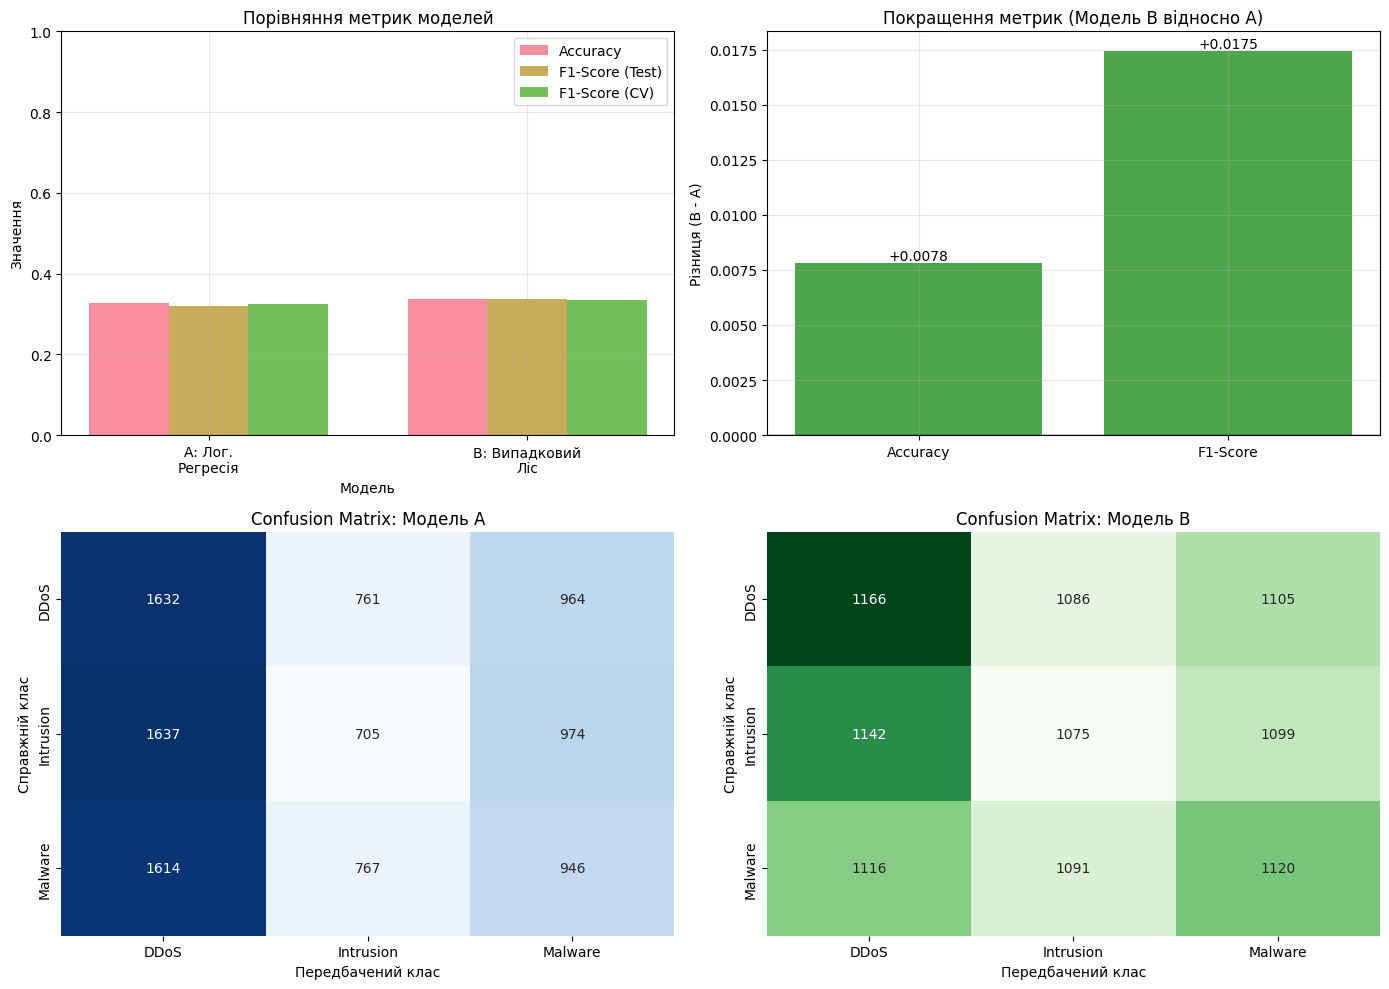

In [52]:
# Порівняння передбачень
diff = f1_b - f1_a
rel_improvement = (diff / f1_a) * 100 if f1_a > 0 else 0

print("\n" + "-"*80)
print("РЕЗУЛЬТАТИ:")
print("-"*80)
if abs(diff) < 0.01:
    print(f"СТАТИСТИЧНО НЕЗНАЧУЩА РІЗНИЦЯ")
    print(f"   Різниця F1-міри: {diff:+.4f} ({rel_improvement:+.2f}%)")
    print(f"   Обидві моделі показують подібну продуктивність")
elif f1_b > f1_a:
    print(f"ВИСНОВОК: Модель B (Випадковий Ліс)")
    print(f"   Абсолютне покращення F1-міри: +{diff:.4f}")
    print(f"   Відносне покращення: +{rel_improvement:.2f}%")
else:
    print(f"ВИСНОВОК: Модель A (Логістична Регресія)")
    print(f"   Абсолютне покращення F1-міри: +{abs(diff):.4f}")
    print(f"   Відносне покращення: +{abs(rel_improvement):.2f}%")

# Візуалізація порівняння
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Графік 1: Порівняння метрик
ax1 = axes[0, 0]
x = np.arange(len(results_df))
width = 0.25
ax1.bar(x - width, results_df['Accuracy'], width, label='Accuracy', alpha=0.8)
ax1.bar(x, results_df['F1-Score'], width, label='F1-Score (Test)', alpha=0.8)
ax1.bar(x + width, results_df['F1-Score CV'], width, label='F1-Score (CV)', alpha=0.8)
ax1.set_xlabel('Модель')
ax1.set_ylabel('Значення')
ax1.set_title('Порівняння метрик моделей')
ax1.set_xticks(x)
ax1.set_xticklabels(['A: Лог.\nРегресія', 'B: Випадковий\nЛіс'])
ax1.legend()
ax1.set_ylim([0, 1])
ax1.grid(True, alpha=0.3)


# Графік 2: Різниця в метриках
ax2 = axes[0, 1]
delta_acc = accuracy_b - accuracy_a
delta_f1 = f1_b - f1_a
metrics = ['Accuracy', 'F1-Score']
deltas = [delta_acc, delta_f1]
colors_bar = ['green' if d > 0 else 'red' for d in deltas]
ax2.bar(metrics, deltas, color=colors_bar, alpha=0.7)
ax2.set_ylabel('Різниця (B - A)')
ax2.set_title('Покращення метрик (Модель B відносно A)')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.grid(True, alpha=0.3)
for i, (m, d) in enumerate(zip(metrics, deltas)):
    ax2.text(i, d, f'{d:+.4f}', ha='center', va='bottom' if d > 0 else 'top')

# Графік 3: Confusion Matrix для Моделі A
ax3 = axes[1, 0]
cm_a = confusion_matrix(y_test, y_pred_a)
sns.heatmap(cm_a, annot=True, fmt='d', cmap='Blues', ax=ax3, 
            xticklabels=le.classes_, yticklabels=le.classes_, cbar=False)
ax3.set_title('Confusion Matrix: Модель A')
ax3.set_ylabel('Справжній клас')
ax3.set_xlabel('Передбачений клас')

# Графік 4: Confusion Matrix для Моделі B
ax4 = axes[1, 1]
cm_b = confusion_matrix(y_test, y_pred_b)
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Greens', ax=ax4,
            xticklabels=le.classes_, yticklabels=le.classes_, cbar=False)
ax4.set_title('Confusion Matrix: Модель B')
ax4.set_ylabel('Справжній клас')
ax4.set_xlabel('Передбачений клас')

plt.tight_layout()
plt.show()






Аналіз важливості ознак (Random Forest)...


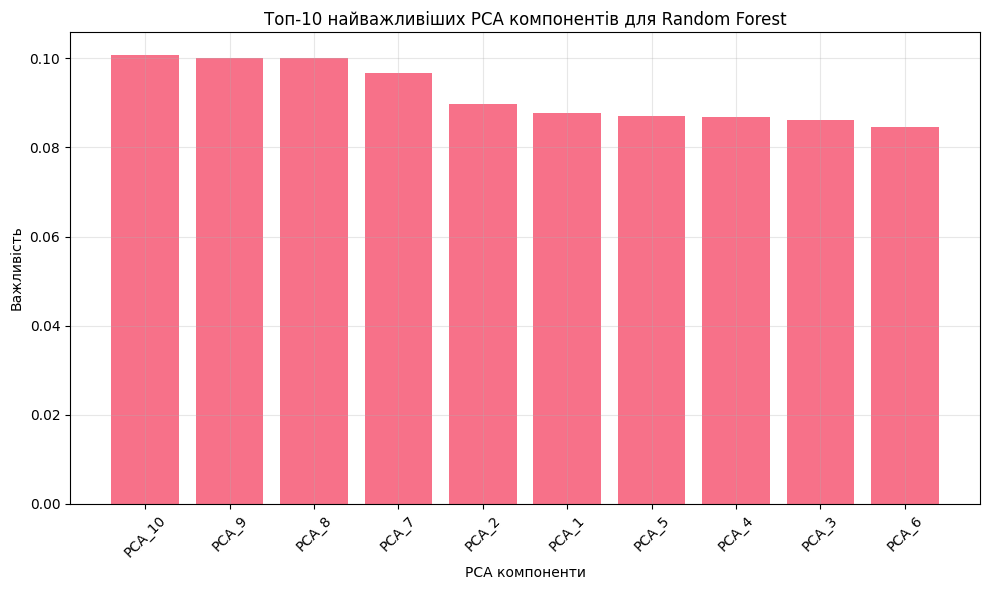

In [ ]:
# Важливість ознак для Random Forest
if hasattr(model_b.best_estimator_, 'feature_importances_'):
    print("\nАналіз важливості ознак (Random Forest)...")
    importances = model_b.best_estimator_.feature_importances_
    feature_names = [f'PCA_{i+1}' for i in range(n_components)]
    
    # Топ-10 найважливіших ознак
    indices = np.argsort(importances)[::-1][:10]
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(indices)), importances[indices])
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45)
    plt.xlabel('PCA компоненти')
    plt.ylabel('Важливість')
    plt.title('Топ-10 найважливіших PCA компонентів для Random Forest')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()